In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

SyntaxError: incomplete input (3796260396.py, line 18)

In [8]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt


# importing data
# Read the 2D array back from the text file

dir_path = "/kaggle/input/dp-5-30-2/d_big(-5_30)"
print(dir_path)
#print("Files in the directory:")
#print(os.listdir(dir_path))

data_needed = {'GRB': 800, 'TGF': 800, 'SGR': 400, 'SFLARE': 800}

event_types = {1:'GRB',2:'TGF',3:'SGR',4:'SFLARE'}
event_counter = {'GRB':0,'TGF':0,'SGR':0,'SFLARE':0}
# Replace 'your_search_string' with the string you are looking for in file names
search_string = 'bn'
search_pattern = os.path.join(dir_path, f'*{search_string}*')
#print(search_pattern)
matching_files = glob.glob(search_pattern)
#print(matching_files)

X_data = []
Y_data = []

for file in matching_files:
    event_type, event_name = os.path.basename(file).split('_')
    if (event_type== "DISTPAR"):
        continue
        
    if event_counter[event_type] < data_needed[event_type]:
        loaded_data = np.loadtxt(file, dtype=np.int16, delimiter='\t').astype(np.int16)
        X_data.append(loaded_data)
    
        y = [0,0,0,0]
        for key,value in event_types.items():
            if value in file.split('\\')[-1]:
                #print(value, file)
                y[key-1] = 1
                Y_data.append(y)
                event_counter[value] += 1
                break
 
    if all(count >= 400 for count in event_counter.values()):
        break
            
print(event_counter)  
X_data = np.array(X_data)
Y_data = np.array(Y_data)
print(X_data.shape)
print(Y_data.shape)

/kaggle/input/dp-5-30-2/d_big(-5_30)


/tmp/ipykernel_34/1223904279.py:35: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  loaded_data = np.loadtxt(file, dtype=np.int16, delimiter='\t').astype(np.int16)


{'GRB': 800, 'TGF': 800, 'SGR': 400, 'SFLARE': 800}
(2800, 45955)
(2800, 4)


In [9]:
import imblearn
from imblearn.over_sampling import SMOTE

oversample = SMOTE()

X_balanced, Y_balanced = oversample.fit_resample(X_data, Y_data)
print(X_balanced.shape)
print(Y_balanced.shape)
print(X_data.shape)
print(Y_data.shape)

(3200, 45955)
(3200, 4)
(2800, 45955)
(2800, 4)


In [11]:
from sklearn.model_selection import train_test_split

print("X_balanced shape : ",X_balanced.shape)
print("Y_balanced_shape : ",Y_balanced.shape)
X_train, X_val, Y_train, Y_val = train_test_split(X_balanced, Y_balanced, test_size = 0.25,stratify=Y_balanced)#, random_state=42)
print("X_train shape",X_train.shape)
print("X_test shape",X_val.shape)
print("Y_train shape",Y_train.shape)
print("Y_test shape",Y_val.shape)
print(X_data.shape)

X_balanced shape :  (3200, 45955)
Y_balanced_shape :  (3200, 4)
X_train shape (2400, 45955)
X_test shape (800, 45955)
Y_train shape (2400, 4)
Y_test shape (800, 4)
(2800, 45955)


In [21]:
import tensorflow as tf
from keras import layers, models,regularizers
from keras.callbacks import EarlyStopping

tf.random.set_seed(42)
# Build the CNN model
model = models.Sequential()
model.add(layers.Conv1D(64, 4, activation='relu', input_shape=(X_train.shape[1:])+tuple([1]),kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.MaxPooling1D((5)))
model.add(layers.Conv1D(32,1, activation='relu',kernel_regularizer=regularizers.l2(0.02)))
model.add(layers.MaxPooling1D((5)))
model.add(layers.Dropout(0.45))
model.add(layers.Conv1D(16,1, activation='relu',kernel_regularizer=regularizers.l2(0.02)))
model.add(layers.MaxPooling1D((5)))
model.add(layers.Dropout(0.4))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(4, activation='softmax',kernel_regularizer=regularizers.l2(0.01)))
model.summary()
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=20)

epoch = 85
# Train the model
history = model.fit(X_train, Y_train, epochs=epoch, batch_size=64, validation_data=(X_val, Y_val))#,callbacks=[early_stopping])

# Evaluate the model on the test set
train_loss, train_acc = model.evaluate(X_train, Y_train)
print(f'\n accuracy on training data: {train_acc} \n \n')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_val, Y_val, verbose=2)
print(f'accuracy on test data: {test_acc}')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 45952, 64)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 9190, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 9190, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 1838, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1838, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 1838, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 367, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 367, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 5872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │       375,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,332 (1.49 MB)

 Trainable params: 389,332 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/85
38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 477ms/step - accuracy: 0.2768 - loss: 10.1005 - val_accuracy: 0.4487 - val_loss: 5.0957
Epoch 2/85
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 331ms/step - accuracy: 0.4310 - loss: 5.0948 - val_accuracy: 0.5437 - val_loss: 4.5379
Epoch 3/85
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 331ms/step - accuracy: 0.5363 - loss: 4.6172 - val_accuracy: 0.5838 - val_loss: 4.1790
Epoch 4/85
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 331ms/step - accuracy: 0.6090 - loss: 4.2055 - val_accuracy: 0.5987 - val_loss: 3.9765
Epoch 5/85
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 331ms/step - accuracy: 0.6419 - loss: 3.9658 - val_accuracy: 0.6288 - val_loss: 3.8090
Epoch 6/85
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 331ms/step - accuracy: 0.6509 - loss: 3.7137 - val_accuracy: 0.6775 - val_loss: 3.5706
Epoch 7/85
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 331ms/step - accuracy: 0.6632 - loss: 3.6144 - val_accuracy: 0.6550 - val_loss: 3.4365
Epoch 8/85
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 331ms/step - accuracy: 0.6782 - loss: 3.4031 - val_acc

In [23]:
# Evaluate the model on the test set
train_loss, train_acc = model.evaluate(X_train, Y_train)
print(f'\n accuracy on training data: {train_acc} \n \n')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_val, Y_val, verbose=2)
print(f'accuracy on test data: {test_acc}')

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8530 - loss: 0.8507

 accuracy on training data: 0.8429166674613953 
 

25/25 - 0s - 5ms/step - accuracy: 0.8438 - loss: 0.9089
accuracy on test data: 0.84375


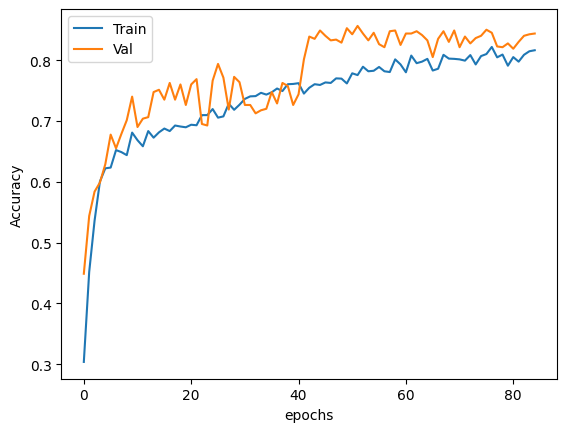

In [24]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(epoch)], history.history['accuracy'],label='Train')
plt.plot([i for i in range(epoch)], history.history['val_accuracy'],label='Val')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()

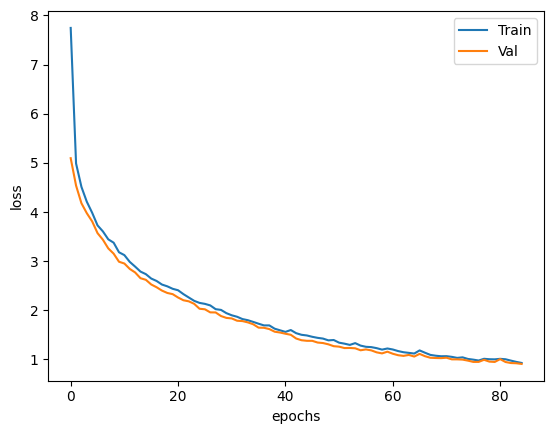

In [25]:
## import matplotlib.pyplot as plt
plt.plot([i for i in range(epoch)], history.history['loss'],label='Train')
plt.plot([i for i in range(epoch)], history.history['val_loss'],label='Val')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


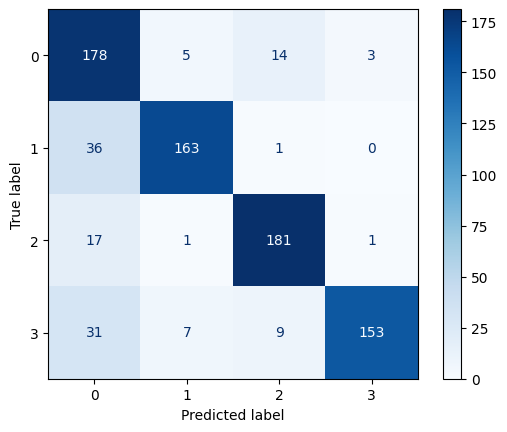

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_prediction = model.predict(X_val)
test_predicted_label = np.argmax(test_prediction, axis=1)
test_actual_label = np.argmax(Y_val, axis = 1)
conf_m = confusion_matrix(test_actual_label, test_predicted_label)

conf_m_show = ConfusionMatrixDisplay(confusion_matrix = conf_m)
conf_m_show.plot(include_values=True, cmap='Blues',ax = None, xticks_rotation= 'horizontal')
plt.show()

In [27]:
import json

# Save the model
model.save('/kaggle/working/saved_(-5_30)_2m_balanced_3.h5')

# Save additional details using JSON
details = {
    'dataset': '(-5_30)_2m',
    'data' : [800,800,800,800],
    'architecture': 'CNN_balanced',
    'parameters': {
        'epochs': 90,
        'batch_size': 64,
        'learning_rate': 0.001,
        '2_Drop_out':[0.4,'after_sec',0.3,'after_third'],
        'l2regularizer' : ['0.01_input','0.02_conv','0.01_dense'],
        'kernel_size':4,
        'filters':{
            'input_layer':64,
            'first_conv':32,
            'second_conv':16
        },
        'v_acc': 0.8162500262260437,
        't_acc': 0.8441666960716248,
        'Dense_layers': [64,64,64,32,4]     
    }
}

with open('/kaggle/working/model_detail_m_balanced_2.json', 'w') as f:
    json.dump(details, f)


In [28]:
from keras.models import load_model

lmodel_2 = load_model(r"/kaggle/working/saved_(-5_30)_2m_balanced_3.h5")
lmodel_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 45952, 64)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 9190, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 9190, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 1838, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1838, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 1838, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 367, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 367, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 5872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │       375,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,334 (1.49 MB)

 Trainable params: 389,332 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [29]:
def model_conf_u(model,X,Y,conf_threshold = 0.6):
    conf=[]
    a = 0
    w = 0
    uncert = 0

    for n in range(len(Y)):
        
        x = X[n].reshape(1, X[n].shape[0], 1)
        y = Y[n].tolist()

        y_pred = model.predict(x, verbose = 0).tolist()[0]

        max_value = y_pred[0]
        max_index = 0

        for i, value in enumerate(y_pred):
            if value > max_value:
                max_value = value
                max_index = i

        if max_value > conf_threshold:
            if y.index(max(y)) == max_index:
                conf.append(max_value)
                a = a+1
            else:
                w = w+1
        else:
            uncert = uncert+1
    
    print('confidently right', a/len(Y))
    print('confidently wrong', w/len(Y))
    print('uncertain', uncert/len(Y))

model_conf_u(lmodel_2,X_balanced,Y_balanced,0.6)

confidently right 0.720625
confidently wrong 0.05625
uncertain 0.223125


In [30]:
def model_conf(model, X, Y, conf_threshold=0.6):
    conf_right = []
    conf_wrong = []

    for n in range(len(Y)):
        x = X[n].reshape(1, X[n].shape[0], 1)  # Reshape each data point to (1, 45955, 1)

        y = Y[n].tolist()
        y_pred = model.predict(x, verbose=0).tolist()[0]
        
        max_value = y_pred[0]
        max_index = 0

        for i, value in enumerate(y_pred):
            if value > max_value:
                max_value = value
                max_index = i

        if y.index(max(y)) == max_index and max_value > conf_threshold:
            conf_right.append(max_value)
        else:
            conf_wrong.append(max_value)            

    return len(conf_right) / (len(conf_right) + len(conf_wrong)), conf_right, conf_wrong

a,r,w = model_conf(lmodel_2,X_balanced,Y_balanced,0.6)

print(a)
print('average conf when right',sum(r)/len(r))
print('average conf when wrong',sum(w)/len(w))

0.720625
average conf when right 0.8779352773610964
average conf when wrong 0.5401726804790348
